# TAAR – Evaluating existing recommenders

Not every recommender can always make a recommendation. To evaluate the individual recommenders for the ensemble, we want to find out how often this is the case and how well the recommenders complement each other.

This notebook either needs to be executed in the [TAAR](http://github.com/mozilla/taar) repository or somewhere where TAAR is in the Python path, because some TAAR recommenders are loaded in.

## Retrieving the relevant variables from the longitudinal dataset

In [140]:
%%time
frame = sqlContext.sql("""
WITH valid_clients AS (
    SELECT *
    FROM longitudinal
    WHERE normalized_channel='release' AND build IS NOT NULL AND build[0].application_name='Firefox'
)

SELECT
    client_id,
    map_keys(active_addons[0]) as installed_addons,
    settings[0].locale AS locale,
    geo_city[0] AS geoCity,
    subsession_length[0] AS subsessionLength,
    system_os[0].name AS os,
    scalar_parent_browser_engagement_total_uri_count[0].value AS total_uri,
    scalar_parent_browser_engagement_tab_open_event_count[0].value as tab_open_count,
    places_bookmarks_count[0].sum as bookmark_count,
    scalar_parent_browser_engagement_unique_domains_count[0].value as unique_tlds,
    profile_creation_date[0] as profile_date,
    submission_date[0] as submission_date
FROM valid_clients
""")

rdd = frame.rdd

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 459 ms


## Loading addon data (AMO)

We need to load the addon database to find out which addons are considered useful by TAAR.

In [141]:
import boto3
import json
import logging

from botocore.exceptions import ClientError

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

AMO_DUMP_BUCKET = 'telemetry-parquet'
AMO_DUMP_KEY = 'telemetry-ml/addon_recommender/addons_database.json'

In [142]:
def load_amo_external_whitelist():
    """ Download and parse the AMO add-on whitelist.
    :raises RuntimeError: the AMO whitelist file cannot be downloaded or contains
                          no valid add-ons.
    """
    final_whitelist = []
    amo_dump = {}
    try:
        # Load the most current AMO dump JSON resource.
        s3 = boto3.client('s3')
        s3_contents = s3.get_object(Bucket=AMO_DUMP_BUCKET, Key=AMO_DUMP_KEY)
        amo_dump = json.loads(s3_contents['Body'].read())
    except ClientError:
        logger.exception("Failed to download from S3", extra={
            "bucket": AMO_DUMP_BUCKET,
            "key": AMO_DUMP_KEY})

    # If the load fails, we will have an empty whitelist, this may be problematic.
    for key, value in amo_dump.items():
        addon_files = value.get('current_version', {}).get('files', {})
        # If any of the addon files are web_extensions compatible, it can be recommended.
        if any([f.get("is_webextension", False) for f in addon_files]):
            final_whitelist.append(value['guid'])

    if len(final_whitelist) == 0:
        raise RuntimeError("Empty AMO whitelist detected")

    return final_whitelist

In [143]:
whitelist = set(load_amo_external_whitelist())

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com


## Filtering out legacy addons 

This is a helper function that takes a list of addon IDs and only returns the IDs of addons that are useful for TAAR.

In [144]:
def get_whitelisted_addons(installed_addons):
    return whitelist.intersection(installed_addons)

## Completing client data

In [145]:
from dateutil.parser import parse as parse_date
from datetime import datetime

In [146]:
def compute_weeks_ago(formatted_date):
    try:
        date = parse_date(formatted_date).replace(tzinfo=None)
    except ValueError: # raised when the date is in an unknown format
        return float("inf")
    
    days_ago = (datetime.today() - date).days
    return days_ago / 7

In [147]:
def complete_client_data(client_data):
    client = client_data.asDict()
    
    addons = client['installed_addons'] or []
    client['installed_addons'] = get_whitelisted_addons(addons)
    client['disabled_addon_ids'] = addons
    
    client['locale'] = str(client['locale'])
    client['profile_age_in_weeks'] = compute_weeks_ago(client['profile_date'])
    client['submission_age_in_weeks'] = compute_weeks_ago(client['submission_date'])
    
    return client

## Evaluating the existing recommenders

To check if a recommender is able to make a recommendation, it's sometimes easier and cleaner to directly query it instead of checking the important attributes ourselves. For example, this is the case for the locale recommender.

In [148]:
from taar.recommenders import CollaborativeRecommender, LegacyRecommender, LocaleRecommender

In [149]:
class DummySimilarityRecommender:
    def can_recommend(self, client_data):
        REQUIRED_FIELDS = ["geoCity", "subsessionLength", "locale", "os", "bookmark_count", "tab_open_count",
                           "total_uri", "unique_tlds"]

        has_fields = all([client_data.get(f, None) is not None for f in REQUIRED_FIELDS])
        return has_fields

In [150]:
recommenders = {
    "collaborative": CollaborativeRecommender(),
    "legacy": LegacyRecommender(),
    "locale": LocaleRecommender(),
    "similarity": DummySimilarityRecommender()
}

INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com


In [151]:
def test_recommenders(client):
    return tuple([recommender.can_recommend(client) for recommender in recommenders.values()])

## Computing combined counts

We iterate over all clients in the longitudinal dataset, change the attributes to the expected format and then query the individual recommenders.

In [152]:
from operator import add
from collections import defaultdict

In [153]:
rdd_completed = rdd.map(complete_client_data)

In [155]:
def analyse(rdd):
    results = rdd\
        .map(test_recommenders)\
        .map(lambda x: (x, 1))\
        .reduceByKey(add)\
        .collect()
        
    return defaultdict(int, results)

In [156]:
%time results = analyse(rdd_completed)

CPU times: user 1.23 s, sys: 112 ms, total: 1.34 s
Wall time: 27min 51s


In [157]:
num_clients = sum(results.values())
total_results = results

## Computing individual counts

In [158]:
individual_counts = []

for i in range(len(recommenders)):
    count = 0
    
    for key, key_count in results.items():
        if key[i]:
            count += key_count
            
    individual_counts.append(count)

## Displaying the results

In [165]:
from pandas import DataFrame

In [166]:
def format_int(num):
    return "{:,}".format(num)

In [167]:
def format_frequency(frequency):
    return "%.5f" % frequency

In [168]:
def get_relative_counts(counts, total=num_clients):
    return [format_frequency(count / float(total)) for count in counts]

This is a bit hacky. Sorting a data frame by formatted counts does not work; so we have to add the unformatted ones, sort the data frame, and then remove that column again.

In [169]:
def sorted_dataframe(df, order, key="unformatted_counts"):
    df[key] = order
    return df.sort_values(by=key, ascending=False).drop(key, axis=1)

### Individual counts

In [170]:
df = DataFrame(index=recommenders.keys(),
          columns=["Relative count"],
          data=get_relative_counts(individual_counts)
)

sorted_dataframe(df, individual_counts)

,Relative count
locale,0.99977
similarity,0.28334
collaborative,0.08348
legacy,0.01808


$\implies$ The locale and collaborative recommenders are able to generate recommendations most of the time. The legacy recommender can only make recommendations very seldomly as not many users seem to have (legacy) addons installed.

### Combined counts

It's interesting to see how well the individual recommenders complement each other. In the following, we count how often different combinations of the recommenders can make recommendations.

The table is easier to read if cells are empty if a recommender is not available. If this is not desired, these variables can be changed:

In [172]:
recommender_available_label = "Available"
recommender_unavailable_label = ""

In [173]:
def format_labels(keys):
    return tuple([recommender_available_label if key else recommender_unavailable_label for key in keys])

In [174]:
def format_data(keys, counts):
    formatted_keys = map(format_labels, keys)
    return [elems + count for elems, count in zip(formatted_keys, zip(*counts))]

In [175]:
columns = recommenders.keys() + ["Relative counts"]

counts = get_relative_counts(results.values())
data = format_data(results.keys(), [counts])

In [176]:
df = DataFrame(columns=columns, data=data)
sorted_dataframe(df, results.values())

,locale,legacy,collaborative,similarity,Relative counts
2,Available,,,,0.66291
7,Available,,,Available,0.24431
4,Available,,Available,,0.04334
0,Available,,Available,Available,0.03113
12,Available,Available,,,0.00552
13,Available,Available,Available,,0.00473
9,Available,Available,Available,Available,0.00426
1,Available,Available,,Available,0.00357
3,,,,,0.00016
15,,,,Available,0.00005


$\implies$ If any recommender is available, then the locale recommenders is generally also available. Other than that, there is a good chance the the collaborative recommender is available.
There is only a very small portion of cases where the similarity recommender was able to make a recommendation, when locale/collaborative were not; and not a single such case for the legacy recommender.

### Grouped by number of available recommenders

In [177]:
from itertools import groupby
from operator import itemgetter

In [178]:
from IPython.display import display, Markdown

In [179]:
for num, group in groupby(sorted(results.keys(), key=sum), sum):
    display(Markdown("#### %d available recommender%s" % (num, "s" if num != 1 else "")))
    
    sub_keys = list(group)
    formatted_keys = map(format_labels, sub_keys)
    
    sub_counts = [results[key] for key in sub_keys]
    sub_counts_to_total = get_relative_counts(sub_counts)
    sub_counts_to_table = get_relative_counts(sub_counts, sum(sub_counts))
    
    zipped_data = zip(formatted_keys, sub_counts_to_total, sub_counts_to_table)
    data = [elems + (counts, table_counts) for elems, counts, table_counts in zipped_data]
    
    columns = recommenders.keys() + ["Relative to all", "Relative to this table"]
    
    df = DataFrame(columns=columns, data=data)
    df = sorted_dataframe(df, sub_counts)
    display(df)

#### 0 available recommenders

,locale,legacy,collaborative,similarity,Relative to all,Relative to this table
0,,,,,0.00016,1.00000


#### 1 available recommender

,locale,legacy,collaborative,similarity,Relative to all,Relative to this table
0,Available,,,,0.66291,0.99991
3,,,,Available,0.00005,0.00008
1,,,Available,,0.00001,0.00002
2,,Available,,,0.00000,0.00000


#### 2 available recommenders

,locale,legacy,collaborative,similarity,Relative to all,Relative to this table
2,Available,,,Available,0.24431,0.83332
0,Available,,Available,,0.04334,0.14783
4,Available,Available,,,0.00552,0.01883
5,,,Available,Available,0.00001,0.00002
3,,Available,Available,,0.00000,0.00000
1,,Available,,Available,0.00000,0.00000


#### 3 available recommenders

,locale,legacy,collaborative,similarity,Relative to all,Relative to this table
0,Available,,Available,Available,0.03113,0.78950
3,Available,Available,Available,,0.00473,0.11987
1,Available,Available,,Available,0.00357,0.09061
2,,Available,Available,Available,0.00000,0.00002


#### 4 available recommenders

,locale,legacy,collaborative,similarity,Relative to all,Relative to this table
0,Available,Available,Available,Available,0.00426,1.00000


## By dates

In this section, we perform a similar analysis as before but on subsets of the data. These subsets are specified by when the client profile was generated. `conditions` is a list that contains ranges for the profile age in weeks. The end of the range is exclusive, similar to ranges in Python's standard library.

In [180]:
conditions = [
    (0, 1),
    (1, 2),
    (2, 3),
    (3, 4)
]

In [181]:
import numpy as np
from numpy import argsort
from itertools import product

In [182]:
def attribute_between(attr, min_weeks, max_weeks):
    return lambda client: min_weeks <= client[attr] < max_weeks

In [183]:
def get_conditioned_results(attr, conditions):
    conditioned_results = {}

    for (min_weeks, max_weeks) in conditions:
        sub_rdd = rdd_completed.filter(attribute_between(attr, min_weeks, max_weeks))
        conditioned_results[(min_weeks, max_weeks)] = analyse(sub_rdd)
        
    return conditioned_results

### By profile age in weeks

In [ ]:
%time conditioned_results = get_conditioned_results("profile_age_in_weeks", conditions)

CPU times: user 5.25 s, sys: 404 ms, total: 5.65 s
Wall time: 1h 51min 25s


To make things a little bit easier to read, only recommender combinations that actually appear are displayed in the table.

In [ ]:
def nonzero_combinations(conditioned_results):
    combinations = []

    for sub_result in conditioned_results.values():
        combinations += [key for key, value in sub_result.items() if value > 0]

    return set(combinations)

In [ ]:
combinations = nonzero_combinations(conditioned_results)

In [ ]:
def display_individual_filtered_results(conditioned_results, combinations, label):
    display(Markdown("### Filtering on the %s, Python-like exclusive ranges" % label))

    counts = []
    titles = []

    columns = recommenders.keys() + ["Relative counts"]

    for key in conditions:
        sub_results = conditioned_results[key]
        values = [sub_results[sub_key] for sub_key in combinations]
        summed = sum(values)

        sub_counts = get_relative_counts(values, summed)
        data = format_data(combinations, [sub_counts])
        counts.append(sub_counts)

        title = "Between %d and %d weeks" % key
        titles.append(title)
        display(Markdown("#### %s" % title))

        df = DataFrame(columns=columns, data=data)
        df = sorted_dataframe(df, values)
        display(df)

    return counts, titles

In [ ]:
counts, titles = display_individual_filtered_results(conditioned_results, combinations, label="profile age")

### Filtering on the profile age, Python-like exclusive ranges

#### Between 0 and 1 weeks

,locale,legacy,collaborative,similarity,Relative counts
2,Available,,,,0.78495
6,Available,,,Available,0.17204
0,Available,,Available,Available,0.03226
3,Available,,Available,,0.01075
1,Available,Available,,Available,0.00000
4,,,,Available,0.00000
5,,,Available,Available,0.00000
7,Available,Available,Available,Available,0.00000
8,,,,,0.00000
9,Available,Available,,,0.00000


#### Between 1 and 2 weeks

,locale,legacy,collaborative,similarity,Relative counts
2,Available,,,,0.77836
6,Available,,,Available,0.18203
3,Available,,Available,,0.02068
0,Available,,Available,Available,0.01121
10,Available,Available,Available,,0.00285
7,Available,Available,Available,Available,0.00210
9,Available,Available,,,0.00185
1,Available,Available,,Available,0.00085
8,,,,,0.00007
4,,,,Available,0.00000


#### Between 2 and 3 weeks

,locale,legacy,collaborative,similarity,Relative counts
2,Available,,,,0.75097
6,Available,,,Available,0.20579
3,Available,,Available,,0.02025
0,Available,,Available,Available,0.01429
7,Available,Available,Available,Available,0.00251
10,Available,Available,Available,,0.00245
9,Available,Available,,,0.00215
1,Available,Available,,Available,0.00148
8,,,,,0.00008
4,,,,Available,0.00001


#### Between 3 and 4 weeks

,locale,legacy,collaborative,similarity,Relative counts
2,Available,,,,0.73514
6,Available,,,Available,0.21937
3,Available,,Available,,0.02197
0,Available,,Available,Available,0.01539
9,Available,Available,,,0.00222
7,Available,Available,Available,Available,0.00213
10,Available,Available,Available,,0.00199
1,Available,Available,,Available,0.00159
8,,,,,0.00014
4,,,,Available,0.00005


To make things a little bit easier to read, we can display all results in a single table.

In [ ]:
def display_merged_filtered_results(counts, titles, total_results, combinations, label):
    values = [total_results[sub_key] for sub_key in combinations]
    sub_counts = get_relative_counts(values)
    counts.append(sub_counts)
    titles.append("Total, without any condition")  

    columns = recommenders.keys() + titles
    data = format_data(combinations, counts)

    df = DataFrame(columns=columns, data=data)
    df = sorted_dataframe(df, counts[0])

    display(Markdown("### Filtering on the %s, Python-like exclusive ranges – All in one table" % label))
    display(df)

In [ ]:
display_merged_filtered_results(counts, titles, total_results, combinations, label="profile age")

### Filtering on the profile age, Python-like exclusive ranges – All in one table

,locale,legacy,collaborative,similarity,Between 0 and 1 weeks,Between 1 and 2 weeks,Between 2 and 3 weeks,Between 3 and 4 weeks,"Total, without any condition"
2,Available,,,,0.78495,0.77836,0.75097,0.73514,0.66291
6,Available,,,Available,0.17204,0.18203,0.20579,0.21937,0.24431
0,Available,,Available,Available,0.03226,0.01121,0.01429,0.01539,0.03113
3,Available,,Available,,0.01075,0.02068,0.02025,0.02197,0.04334
1,Available,Available,,Available,0.00000,0.00085,0.00148,0.00159,0.00357
4,,,,Available,0.00000,0.00000,0.00001,0.00005,0.00005
5,,,Available,Available,0.00000,0.00000,0.00001,0.00000,0.00001
7,Available,Available,Available,Available,0.00000,0.00210,0.00251,0.00213,0.00426
8,,,,,0.00000,0.00007,0.00008,0.00014,0.00016
9,Available,Available,,,0.00000,0.00185,0.00215,0.00222,0.00552


### By submission date in weeks

In [ ]:
%time conditioned_results_submission_date = get_conditioned_results("submission_age_in_weeks", conditions)

CPU times: user 5.2 s, sys: 444 ms, total: 5.64 s
Wall time: 1h 52min 2s


In [1]:
label = "submission date"
combinations = nonzero_combinations(conditioned_results_submission_date)
counts, titles = display_individual_filtered_results(conditioned_results_submission_date, combinations, label)
display_merged_filtered_results(counts, titles, total_results, combinations, label)

NameError: name 'nonzero_combinations' is not defined

## Addon counts

We want to train an ensemble model using the individual recommenders that we already have. To optimize this ensemble model, we need some training data. We have information about what addons different users have installed, so it would make sense to check if our ensemble model would also recommend these addons to the respective users.

However, there is one fundamental conflict here: To be able to make recommendations, the collaborative recommender already needs some information about which addons a user has installed. Thus, we can only use a subset of a user's installed addons for evaluation. These addons are masked and the collaborative recommender then only uses the unmasked addons. The open question is how large this subset of masked addons should be.

Choosing this size is a trade-off between three factors:
1. By masking more addons, we give the evaluation function more data to work with
2. If we mask fewer addons, the collaborative filter can make better recommendations
3. There are not that many users who have many addons installed. This means we need to be careful not to make our evaluation set too biased. For example, if we always mask at least five addons, then only users with more than six addons could be part of the evaluation set, which is a small subset of the entire population

To be able to make this decision, it's helpful to look at the distribution of the number of addons that users have installed.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

In [ ]:
addon_counts = rdd_completed\
    .map(lambda client: len(client['installed_addons']))\
    .map(lambda x: (x, 1))\
    .reduceByKey(add)\
    .collect()
    
addon_counts = sorted(addon_counts, key=itemgetter(0))

In [ ]:
def addon_counts_to_proportions(addon_counts):
    num_addons, num_addons_count = zip(*addon_counts)
    
    num_addons_total = float(sum(num_addons_count))
    num_addons_count = np.array(num_addons_count) / num_addons_total
    
    return num_addons, num_addons_count

In [ ]:
def plot_addon_distribution(addon_counts):
    num_addons, num_addons_count = addon_counts_to_proportions(addon_counts)
    
    plt.bar(num_addons, num_addons_count, width=1.)
    plt.title("Number of addons per user")
    plt.xlabel("Number of addons")
    plt.ylabel("Proportion of users")
    plt.show()
    
    plt.plot(np.cumsum(num_addons_count))
    plt.title("Number of addons per user (cumulative)")
    plt.xlabel("Number of addons")
    plt.ylabel("Proportion of users")
    plt.ylim(0, 1)
    plt.show()

In [ ]:
plot_addon_distribution(addon_counts)

As we can see, there is a substantial number of users that have no addons installed. Nearly all other users have fewer than 10 addons installed. To make the plot a bit easier to read, it's helpful to hide the long tail.

In [ ]:
reasonable_addon_counts = filter(lambda (num_addons, count): num_addons < 15, addon_counts)
plot_addon_distribution(reasonable_addon_counts)

$\implies$ To get an evaluation set of a decent size that's at least partly representative, it's important to include users that only have a few addons installed. One idea could be to mask half of the addons that users in the evaluation set have installed. This way, we would be able to include users that only have a few addons installed. If the number of addons is odd, we could uniformly randomly round up or down.

The alternative would be to make the portion of masked addons a little bit higher or lower. This could make sense if we notice that the collaborative recommender is generally able to make much better recommendations using two addons than using one addon; or, the other way around, if we notice that it adds little value to evaluate based on a single addon.

In [ ]:
num_addons, num_addons_count = addon_counts_to_proportions(addon_counts)
num_addons_count = map(format_frequency, num_addons_count)

DataFrame(
    columns=["Number of addons", "Proportion"],
    data=zip(num_addons, num_addons_count)
).head(40)

---

In [198]:
usr = rdd_completed.filter(lambda user: len(user['disabled_addon_ids']) > 0).first()

In [199]:
usr

{'bookmark_count': 0,
 'client_id': u'ff60062a-2d49-4d12-b7e9-c85d17996eea',
 'disabled_addon_ids': {u'uBlock0@raymondhill.net',
  u'{7b1bf0b6-a1b9-42b0-b75d-252036438bdc}'},
 'geoCity': u'Herne Bay',
 'installed_addons': [u'{C1A2A613-35F1-4FCF-B27F-2840527B6556}',
  u'uBlock0@raymondhill.net',
  u'{7b1bf0b6-a1b9-42b0-b75d-252036438bdc}'],
 'locale': 'en-GB',
 'os': u'Windows_NT',
 'profile_age_in_weeks': 179,
 'profile_date': u'2014-04-28T00:00:00.000Z',
 'submission_age_in_weeks': 1,
 'submission_date': u'2017-09-23T00:00:00.000Z',
 'subsessionLength': 434,
 'tab_open_count': 2,
 'total_uri': 18,
 'unique_tlds': 8}

In [194]:
ler = LegacyRecommender()

In [200]:
client_data = usr
limit = 10

In [204]:
a = set(ler.legacy_replacements.keys())

In [205]:
a.intersection(usr['disabled_addon_ids'])

set()

---

In [187]:
from taar.recommenders import CollaborativeRecommender, LocaleRecommender, LegacyRecommender

In [142]:
user = rdd_completed.first()

In [145]:
cr = CollaborativeRecommender()

INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com


In [148]:
cr.recommend(user, 10)

[u'uBlock0@raymondhill.net',
 u'jid1-HAV2inXAnQPIeA@jetpack',
 u'{7b1bf0b6-a1b9-42b0-b75d-252036438bdc}',
 u'firefox@browser-security.de',
 u'{E0B8C461-F8FB-49b4-8373-FE32E9252800}',
 u'jid0-GXjLLfbCoAx0LcltEdFrEkQdQPI@jetpack',
 u'{72b2e02b-3a71-4895-886c-fd12ebe36ba3}',
 u'firefox@tampermonkey.net',
 u'ffext_basicvideoext@startpage24',
 u'@emojikeyboard']

In [149]:
client_data = user
limit = 10

In [153]:
def java_string_hashcode(s):
    h = 0
    for c in s:
        h = (31 * h + ord(c)) & 0xFFFFFFFF
    return ((h + 0x80000000) & 0xFFFFFFFF) - 0x80000000


def positive_hash(s):
    return java_string_hashcode(s) & 0x7FFFFF

In [157]:
import operator as op

# Addons identifiers are stored as positive hash values within the model.
installed_addons =\
    [positive_hash(addon_id) for addon_id in client_data.get('installed_addons', [])]

# Build the query vector by setting the position of the queried addons to 1.0
# and the other to 0.0.
query_vector = np.array([1.0 if (entry.get("id") in installed_addons) else 0.0
                         for entry in cr.raw_item_matrix])

# Build the user factors matrix.
user_factors = np.matmul(query_vector, cr.model)
user_factors_transposed = np.transpose(user_factors)

distances = {}
for addon in cr.raw_item_matrix:
    # We don't really need to show the items we requested. They will always
    # end up with the greatest score. Also filter out legacy addons from the
    # suggestions.
    hashed_id = str(addon.get("id"))
    if (hashed_id in installed_addons or
            hashed_id not in cr.addon_mapping or
            cr.addon_mapping[hashed_id].get("isWebextension", False) is False):
        continue

    dist = np.dot(user_factors_transposed, addon.get('features'))
    # Read the addon ids from the "addon_mapping" looking it
    # up by 'id' (which is an hashed value).
    addon_id = cr.addon_mapping[hashed_id].get("id")
    distances[addon_id] = dist

# Sort the suggested addons by their score and return the sorted list of addon
# ids.
sorted_dists = sorted(distances.items(), key=op.itemgetter(1), reverse=True)
[s[0] for s in sorted_dists[:limit]]

[u'uBlock0@raymondhill.net',
 u'jid1-HAV2inXAnQPIeA@jetpack',
 u'{7b1bf0b6-a1b9-42b0-b75d-252036438bdc}',
 u'firefox@browser-security.de',
 u'{E0B8C461-F8FB-49b4-8373-FE32E9252800}',
 u'jid0-GXjLLfbCoAx0LcltEdFrEkQdQPI@jetpack',
 u'{72b2e02b-3a71-4895-886c-fd12ebe36ba3}',
 u'firefox@tampermonkey.net',
 u'ffext_basicvideoext@startpage24',
 u'@emojikeyboard']

In [161]:
addon_ids, scores = zip(*sorted_dists)

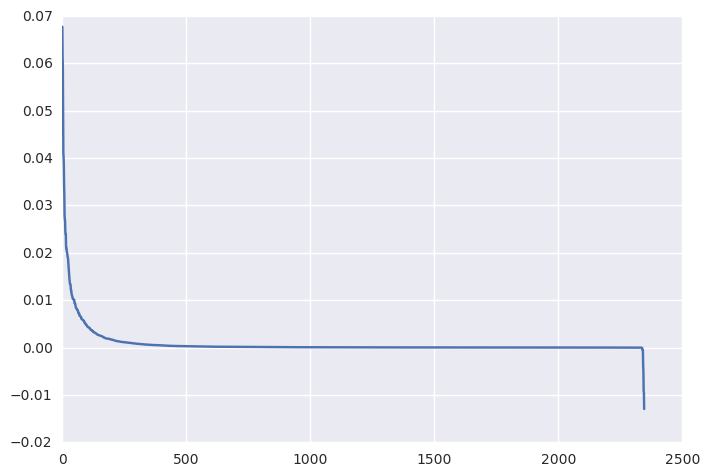

In [162]:
plt.plot(scores)

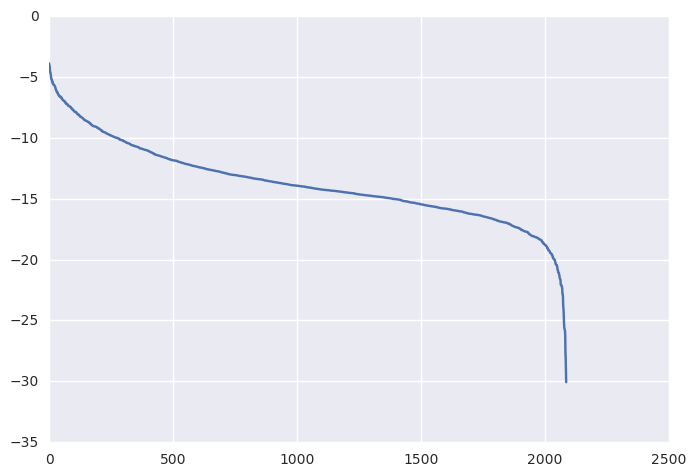

In [185]:
plt.plot(np.log2(scores))

In [188]:
lor = LocaleRecommender()

In [189]:
lor.top_addons_per_locale

{u'ar': [u'mozilla_cc2@internetdownloadmanager.com',
  u'{d10d0bf8-f5b5-c8b4-a8b2-2b9879e08c5d}',
  u'wrc@avast.com',
  u'sp@avast.com',
  u'{82AF8DCA-6DE9-405D-BD5E-43525BDAD38A}',
  u'{4ED1F68A-5463-4931-9384-8FFF5ED91D92}',
  u'helper-sig@savefrom.net',
  u'{de71f09a-3342-48c5-95c1-4b0f17567554}',
  u'light_plugin_ACF0E80077C511E59DED005056C00008@kaspersky.com'],
 u'bg': [u'{d10d0bf8-f5b5-c8b4-a8b2-2b9879e08c5d}',
  u'wrc@avast.com',
  u'{82AF8DCA-6DE9-405D-BD5E-43525BDAD38A}',
  u'jid1-AXn9cXcB4fD1QQ@jetpack',
  u'{b9db16a4-6edc-47ec-a1f4-b86292ed211d}',
  u'jid1-FkPKYIvh3ElkQO@jetpack',
  u'uBlock0@raymondhill.net',
  u'sp@avast.com',
  u'abvnotifier@netinfo.bg'],
 u'bs': [u'{d10d0bf8-f5b5-c8b4-a8b2-2b9879e08c5d}',
  u'ubufox@ubuntu.com',
  u'wrc@avast.com',
  u'{82AF8DCA-6DE9-405D-BD5E-43525BDAD38A}',
  u'uBlock0@raymondhill.net',
  u'{e4a8a97b-f2ed-450b-b12d-ee082ba24781}',
  u'light_plugin_ACF0E80077C511E59DED005056C00008@kaspersky.com',
  u'{b9bfaf1c-a63f-47cd-8b9a-29526ced906